Training: 102, Validation: 55, Seq Length: 8

Training Hybrid LSTM + QNN with Priority 1 improvements...
- Dropout: 0.1
- Learning Rate: 0.001
- Weight Decay: 1e-06
- Loss: Huber (SmoothL1) with Beta : 1.0
- Early stopping patience: 50



C:\Users\acer\anaconda3\Lib\site-packages\pennylane\workflow\qnode.py:135: UserWarning: Received gradient_kwarg max_diff_method, which is not included in the list of standard qnode gradient kwargs.
  warnings.warn(


Epoch  1 | Train Loss: 0.233422 | Val Loss: 0.055734 ✓ (best)
Epoch  2 | Train Loss: 0.230053 | Val Loss: 0.053522 ✓ (best)
Epoch  3 | Train Loss: 0.245483 | Val Loss: 0.051355 ✓ (best)
Epoch  4 | Train Loss: 0.212411 | Val Loss: 0.049249 ✓ (best)
Epoch  5 | Train Loss: 0.208945 | Val Loss: 0.047194 ✓ (best)
Epoch  6 | Train Loss: 0.212351 | Val Loss: 0.045192 ✓ (best)
Epoch  7 | Train Loss: 0.212122 | Val Loss: 0.043229 ✓ (best)
Epoch  8 | Train Loss: 0.210388 | Val Loss: 0.041314 ✓ (best)
Epoch  9 | Train Loss: 0.197015 | Val Loss: 0.039460 ✓ (best)
Epoch 10 | Train Loss: 0.209175 | Val Loss: 0.037645 ✓ (best)
Epoch 11 | Train Loss: 0.200148 | Val Loss: 0.035876 ✓ (best)
Epoch 12 | Train Loss: 0.177837 | Val Loss: 0.034163 ✓ (best)
Epoch 13 | Train Loss: 0.176740 | Val Loss: 0.032503 ✓ (best)
Epoch 14 | Train Loss: 0.186339 | Val Loss: 0.030900 ✓ (best)
Epoch 15 | Train Loss: 0.181005 | Val Loss: 0.029352 ✓ (best)
Epoch 16 | Train Loss: 0.184694 | Val Loss: 0.027845 ✓ (best)
Epoch 17

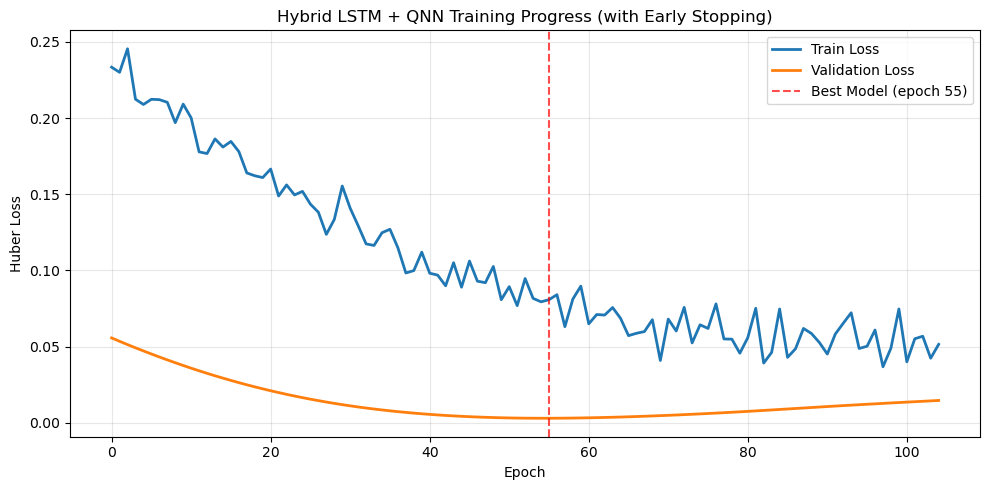


FINAL METRICS (Best Model from Early Stopping)
TRAIN - MSE: 163798.4531, R²: -1.2207, RMSE: 404.72
VAL   - MSE: 13927.7197, R²: 0.3460, RMSE: 118.02
✓ Good generalization (Train R² - Val R² = -1.5667)


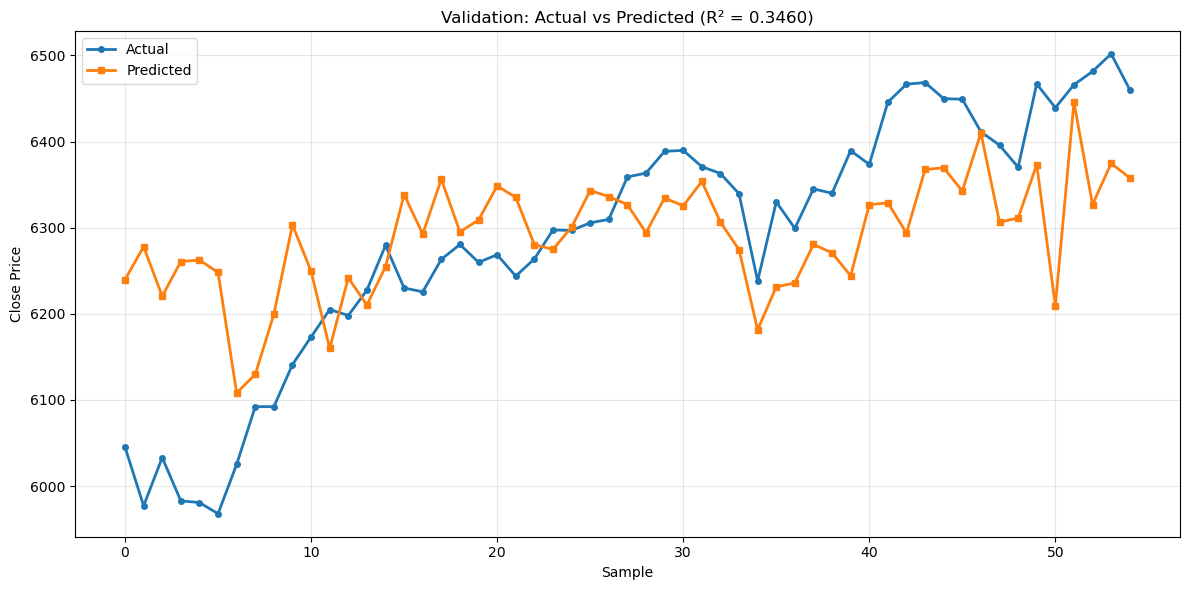


TEST SET PREDICTIONS
      Date  Predicted_Close
2025-09-02      6381.488770
2025-09-03      6316.316895
2025-09-04      6370.878906
2025-09-05      6325.871094
2025-09-08      6287.756836
2025-09-09      6412.341309
2025-09-10      6375.680176
2025-09-11      6357.419922
2025-09-12      6335.991211
2025-09-15      6406.552246


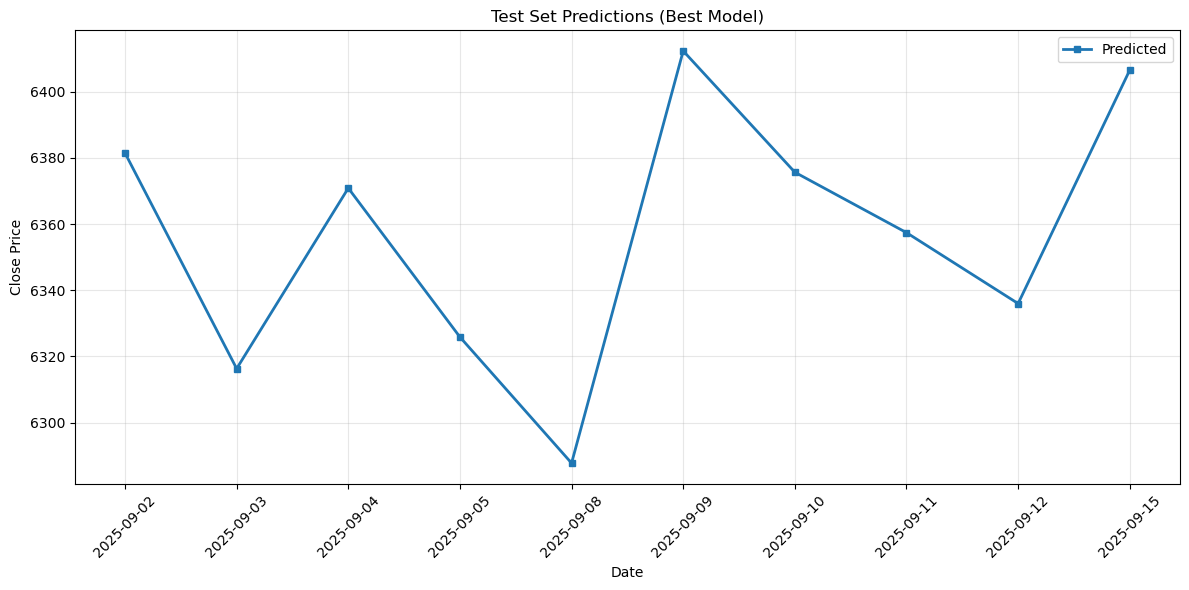

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pennylane as qml


# ============================================================
# REPRODUCIBILITY / SEED
# ============================================================
SEED = 42
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# ============================================================
# DATA PREPARATION
# ============================================================
# Paths
train_path = r"C:\Users\acer\OneDrive\QPoland\X_train.csv"
test_path  = r"C:\Users\acer\OneDrive\QPoland\X_test.csv"

X_train = pd.read_csv(train_path).sort_values("Date")
X_test = pd.read_csv(test_path).sort_values("Date")

def add_simple_features(df):
    df = df.copy()
    df['Price_Range'] = df['High'] - df['Low']
    df['HL_Ratio'] = df['High'] / (df['Low'] + 1e-10)
    df['Volume_MA_3'] = df['Volume'].rolling(window=3, min_periods=1).mean()
    return df.bfill().ffill()

X_train = add_simple_features(X_train)
X_test = add_simple_features(X_test)

features = ["Open", "High", "Low", "Volume", "Price_Range", "HL_Ratio", "Volume_MA_3"]
target = "Close"

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train[features])
y_train_scaled = scaler_y.fit_transform(X_train[[target]])

SEQ_LEN = 8

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LEN)

split = int(len(X_seq) * 0.65)
X_train_t = torch.tensor(X_seq[:split], dtype=torch.float32)
y_train_t = torch.tensor(y_seq[:split], dtype=torch.float32)
X_val_t = torch.tensor(X_seq[split:], dtype=torch.float32)
y_val_t = torch.tensor(y_seq[split:], dtype=torch.float32)

print(f"Training: {len(X_train_t)}, Validation: {len(X_val_t)}, Seq Length: {SEQ_LEN}\n")


# ============================================================
# HYBRID LSTM + QNN PARAMETERS
# ============================================================
input_size = len(features)
n_qubits = 4  # max qubits
hidden_size = n_qubits
dropout_rate = 0.1  # CHANGED: Increased from 0.05 to 0.2 to combat overfitting
n_layers = 2

def xavier_init(in_size, out_size):
    limit = np.sqrt(6.0 / (in_size + out_size))
    return torch.randn(in_size, out_size) * limit

# Classical LSTM gates
W_ii = nn.Parameter(xavier_init(input_size, hidden_size))
W_hi = nn.Parameter(xavier_init(hidden_size, hidden_size))
b_i = nn.Parameter(torch.zeros(hidden_size))

W_if = nn.Parameter(xavier_init(input_size, hidden_size))
W_hf = nn.Parameter(xavier_init(hidden_size, hidden_size))
b_f = nn.Parameter(torch.ones(hidden_size))

W_io = nn.Parameter(xavier_init(input_size, hidden_size))
W_ho = nn.Parameter(xavier_init(hidden_size, hidden_size))
b_o = nn.Parameter(torch.zeros(hidden_size))

W_out = nn.Parameter(xavier_init(hidden_size, 1))
b_out = nn.Parameter(torch.zeros(1))

dropout = nn.Dropout(dropout_rate)


# ============================================================
# QUANTUM LAYER SETUP
# ============================================================
dev = qml.device("default.qubit", wires=n_qubits)

shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = nn.Parameter(0.01 * torch.randn(*shape))

# @qml.qnode(dev, interface="torch")
# def quantum_node(inputs, weights):
#     qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
#     qml.BasicEntanglerLayers(weights=weights, wires=range(n_qubits))
#     return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

@qml.qnode(dev, interface="torch", diff_method="backprop", max_diff_method="finite-diff")
def quantum_node_batch(inputs, weights):
    # inputs shape: (batch_size, n_qubits)
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights=weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


# PCA transformer to reduce input to 4 qubits
pca = PCA(n_components=n_qubits)

# Collect parameters
lstm_params = [W_ii, W_hi, b_i, W_if, W_hf, b_f, W_io, W_ho, b_o, W_out, b_out, weights]


# ============================================================
# HYBRID LSTM FORWARD FUNCTION
# ============================================================
def lstm_forward(x_batch, training=True):
    batch_size = x_batch.shape[0]
    seq_length = x_batch.shape[1]
    h_t = torch.zeros(batch_size, hidden_size)
    c_t = torch.zeros(batch_size, hidden_size)

    for t in range(seq_length):
        x_t = x_batch[:, t, :]
        i_t = torch.sigmoid(x_t @ W_ii + h_t @ W_hi + b_i)
        f_t = torch.sigmoid(x_t @ W_if + h_t @ W_hf + b_f)
        o_t = torch.sigmoid(x_t @ W_io + h_t @ W_ho + b_o)

        # Quantum cell candidate
        concat_input = torch.cat([x_t, h_t], dim=1)
        q_input = torch.tensor(pca.fit_transform(concat_input.detach().numpy()), dtype=torch.float32)

        q_outputs = []
        for i in range(q_input.shape[0]):
            q_out = quantum_node(q_input[i], weights)
            q_outputs.append(torch.tensor(q_out, dtype=torch.float32))
        c_tilde = torch.stack(q_outputs, dim=0)
        c_tilde = torch.tanh(c_tilde)

        if training:
            c_tilde = dropout(c_tilde)

        c_t = f_t * c_t + i_t * c_tilde
        h_t = o_t * torch.tanh(c_t)

    if training:
        h_t = dropout(h_t)

    output = h_t @ W_out + b_out
    return output


# ============================================================
# TRAINING LOOP WITH PRIORITY 1 IMPROVEMENTS
# ============================================================
# CHANGED: Using Adam optimizer with weight decay (L2 regularization)
lr = 0.001
wd = 1e-6
optimizer = optim.Adam(lstm_params, lr=lr, weight_decay=wd)

# CHANGED: Using Huber loss instead of MSE for robustness
beta = 1.0
criterion = nn.SmoothL1Loss(beta=beta)

EPOCHS = 1000  # CHANGED: Increased max epochs (early stopping will prevent overtraining)
train_losses, val_losses = [], []

# NEW: Early stopping parameters
best_val_loss = float('inf')
patience = 50  # Stop if no improvement for 10 epochs
patience_counter = 0
best_state_dict = None

print("Training Hybrid LSTM + QNN with Priority 1 improvements...")
print(f"- Dropout: {dropout_rate}")
print(f"- Learning Rate: {lr}")
print(f"- Weight Decay: {wd}")
#print(f"- Optimizer: Adam with weight_decay=1e-4")
print(f"- Loss: Huber (SmoothL1) with Beta : {beta}")
print(f"- Early stopping patience: {patience}\n")

for epoch in range(1, EPOCHS + 1):
    # Training phase
    dropout.train()
    optimizer.zero_grad()
    train_pred = lstm_forward(X_train_t, training=True)
    train_loss = criterion(train_pred, y_train_t)
    train_loss.backward()
    torch.nn.utils.clip_grad_norm_(lstm_params, max_norm=1.0)
    optimizer.step()
    train_losses.append(train_loss.item())

    # Validation phase
    dropout.eval()
    with torch.no_grad():
        val_pred = lstm_forward(X_val_t, training=False)
        val_loss = criterion(val_pred, y_val_t)
        val_losses.append(val_loss.item())

    # NEW: Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
        # Save best model state
        best_state_dict = {
            'W_ii': W_ii.data.clone(),
            'W_hi': W_hi.data.clone(),
            'b_i': b_i.data.clone(),
            'W_if': W_if.data.clone(),
            'W_hf': W_hf.data.clone(),
            'b_f': b_f.data.clone(),
            'W_io': W_io.data.clone(),
            'W_ho': W_ho.data.clone(),
            'b_o': b_o.data.clone(),
            'W_out': W_out.data.clone(),
            'b_out': b_out.data.clone(),
            'weights': weights.data.clone()
        }
        print(f"Epoch {epoch:2d} | Train Loss: {train_loss.item():.6f} | Val Loss: {val_loss.item():.6f} ✓ (best)")
    else:
        patience_counter += 1
        print(f"Epoch {epoch:2d} | Train Loss: {train_loss.item():.6f} | Val Loss: {val_loss.item():.6f} | Patience: {patience_counter}/{patience}")
        
    # NEW: Stop training if no improvement
    if patience_counter >= patience:
        print(f"\n⚠ Early stopping triggered at epoch {epoch}. Best val loss: {best_val_loss:.6f}")
        break

# NEW: Restore best model weights
if best_state_dict is not None:
    print("\n✓ Restoring best model weights from validation...")
    W_ii.data = best_state_dict['W_ii']
    W_hi.data = best_state_dict['W_hi']
    b_i.data = best_state_dict['b_i']
    W_if.data = best_state_dict['W_if']
    W_hf.data = best_state_dict['W_hf']
    b_f.data = best_state_dict['b_f']
    W_io.data = best_state_dict['W_io']
    W_ho.data = best_state_dict['W_ho']
    b_o.data = best_state_dict['b_o']
    W_out.data = best_state_dict['W_out']
    b_out.data = best_state_dict['b_out']
    weights.data = best_state_dict['weights']


# ============================================================
# PLOTTING TRAINING CURVES
# ============================================================
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.axvline(x=len(val_losses) - patience_counter, color='red', linestyle='--', 
            label=f'Best Model (epoch {len(val_losses) - patience_counter})', alpha=0.7)
plt.title('Hybrid LSTM + QNN Training Progress (with Early Stopping)')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ============================================================
# EVALUATION ON TRAIN/VALIDATION
# ============================================================
dropout.eval()
with torch.no_grad():
    train_pred_final = lstm_forward(X_train_t, training=False).numpy()
    val_pred_final = lstm_forward(X_val_t, training=False).numpy()

train_pred_rescaled = scaler_y.inverse_transform(train_pred_final)
val_pred_rescaled = scaler_y.inverse_transform(val_pred_final)
y_train_orig = scaler_y.inverse_transform(y_train_t.numpy())
y_val_orig = scaler_y.inverse_transform(y_val_t.numpy())

train_mse = mean_squared_error(y_train_orig, train_pred_rescaled)
train_r2 = r2_score(y_train_orig, train_pred_rescaled)
val_mse = mean_squared_error(y_val_orig, val_pred_rescaled)
val_r2 = r2_score(y_val_orig, val_pred_rescaled)

print("\n" + "="*60)
print("FINAL METRICS (Best Model from Early Stopping)")
print("="*60)
print(f"TRAIN - MSE: {train_mse:.4f}, R²: {train_r2:.4f}, RMSE: {np.sqrt(train_mse):.2f}")
print(f"VAL   - MSE: {val_mse:.4f}, R²: {val_r2:.4f}, RMSE: {np.sqrt(val_mse):.2f}")
print("="*60)

# NEW: Show overfitting gap
r2_gap = train_r2 - val_r2
if r2_gap > 0.2:
    print(f"⚠ WARNING: Large overfitting gap detected (Train R² - Val R² = {r2_gap:.4f})")
    print("   Consider: increasing dropout, reducing model complexity, or adding more data")
elif r2_gap > 0.1:
    print(f"⚡ Moderate overfitting detected (Train R² - Val R² = {r2_gap:.4f})")
else:
    print(f"✓ Good generalization (Train R² - Val R² = {r2_gap:.4f})")
print("="*60)


# ============================================================
# PLOT VALIDATION ACTUAL vs PREDICTED
# ============================================================
plt.figure(figsize=(12, 6))
plt.plot(y_val_orig, label='Actual', linewidth=2, marker='o', markersize=4)
plt.plot(val_pred_rescaled, label='Predicted', linewidth=2, marker='s', markersize=4)
plt.title(f'Validation: Actual vs Predicted (R² = {val_r2:.4f})')
plt.xlabel('Sample')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ============================================================
# PREDICTIONS ON TEST DATA
# ============================================================
X_test_scaled = scaler_X.transform(X_test[features])
combined = np.concatenate([X_train_scaled[-SEQ_LEN:], X_test_scaled])
X_test_seq = [combined[i:i+SEQ_LEN] for i in range(len(combined) - SEQ_LEN)]
X_test_t = torch.tensor(np.array(X_test_seq), dtype=torch.float32)

with torch.no_grad():
    test_pred = lstm_forward(X_test_t, training=False).numpy()
test_pred_rescaled = scaler_y.inverse_transform(test_pred)

predicted_closes = pd.DataFrame({
    "Date": X_test["Date"].values[:len(test_pred_rescaled)],
    "Predicted_Close": test_pred_rescaled.flatten()
})

print("\n" + "="*60)
print("TEST SET PREDICTIONS")
print("="*60)
print(predicted_closes.to_string(index=False))
print("="*60)


# ============================================================
# PLOT TEST PREDICTIONS
# ============================================================
plt.figure(figsize=(12, 6))
plt.plot(X_test["Date"].values[:len(test_pred_rescaled)], test_pred_rescaled.flatten(),
         label='Predicted', linewidth=2, marker='s', markersize=4)
plt.title('Test Set Predictions (Best Model)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [44]:
import torch

# Save all parameters to a dictionary
model_params = {
    'W_ii': W_ii.data,
    'W_hi': W_hi.data,
    'b_i': b_i.data,
    'W_if': W_if.data,
    'W_hf': W_hf.data,
    'b_f': b_f.data,
    'W_io': W_io.data,
    'W_ho': W_ho.data,
    'b_o': b_o.data,
    'W_out': W_out.data,
    'b_out': b_out.data,
    'weights': weights.data,
    "scaler_X": scaler_X,        # Save feature scaler
    "scaler_y": scaler_y,        # Save target scaler
    "pca": pca                   # Save PCA transformer
}

# Choose your output file name
torch.save(model_params, 'hybrid_qlstm_model_5.pth')
print("Saved model parameters to hybrid_qlstm_model_5.pth")

'''
# Load model parameters
checkpoint = torch.load('hybrid_qlstm_model.pth')

# Restore each parameter
W_ii.data = checkpoint['W_ii']
W_hi.data = checkpoint['W_hi']
b_i.data = checkpoint['b_i']
W_if.data = checkpoint['W_if']
W_hf.data = checkpoint['W_hf']
b_f.data = checkpoint['b_f']
W_io.data = checkpoint['W_io']
W_ho.data = checkpoint['W_ho']
b_o.data = checkpoint['b_o']
W_out.data = checkpoint['W_out']
b_out.data = checkpoint['b_out']
weights.data = checkpoint['weights']

# Restore scalers and PCA
scaler_X = checkpoint['scaler_X']
scaler_y = checkpoint['scaler_y']
pca = checkpoint['pca']

print("Loaded model parameters from hybrid_qlstm_model.pth")
'''

import json
def to_serializable(val):
    if isinstance(val, (np.generic, np.ndarray)):
        return val.item()  # Converts NumPy scalars to native Python types
    elif isinstance(val, torch.Tensor):
        return val.item()  # Converts 0-dim tensor to Python scalar
    else:
        return val

run_info = {k: to_serializable(v) for k, v in {
    "train_mse": train_mse,
    "train_r2": train_r2,
    "val_mse": val_mse,
    "val_r2": val_r2,
    "dropout_rate": dropout_rate,
    "early_stopping_patience": patience,
    "epochs_run": epoch
}.items()}

with open("hybrid_qlstm_metadata_5.json", "w") as f:
    json.dump(run_info, f, indent=2)


Saved model parameters to hybrid_qlstm_model_5.pth


In [92]:
import pandas as pd

# Data as a dictionary
data = {
    "Date": [
        "2025-09-02", "2025-09-03", "2025-09-04", "2025-09-05", "2025-09-08",
        "2025-09-09", "2025-09-10", "2025-09-11", "2025-09-12", "2025-09-15"
    ],
    "Predicted_Close": [
        6381.488770, 6316.316895, 6370.878906, 6325.871094, 6287.756836,
        6412.341309, 6375.680176, 6357.419922, 6335.991211, 6406.552246
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV file
df.to_csv("test_set_predictions.csv", index=False)

print("Data saved to 'test_set_predictions.csv'.")


Data saved to 'test_set_predictions.csv'.
